In [1]:
import itertools
import numpy as np
from samples.maps import read_samples as read_maps_samples, get_onset_clip
import tensorflow as tf
from tensorflow import keras

note_count = 122
window_size = 4096
channel = 0

max_samples = 500
batch = itertools.islice(read_maps_samples('/datasets/audio/maps'), max_samples)

def prepare_sample(sample):
    clip = get_onset_clip(sample, channel, window_size)
    return [clip['window'], clip['note']]

samples = np.array(list(prepare_sample(sample) for sample in batch)).transpose()

inputs = np.stack(samples[0])
labels = np.stack(samples[1])

labels = tf.keras.utils.to_categorical(labels, num_classes = note_count)

print(inputs.shape)
print(labels.shape)
# tf.convert_to_tensor(inputs)



(500, 4096)
(500, 122)


In [2]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(window_size)))
model.add(keras.layers.Lambda(tf.signal.rfft))
model.add(keras.layers.Dense(window_size/2 + 1, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(note_count, activation='relu'))

model.compile(optimizer=keras.optimizers.Adam(lr=0.001, clipnorm=0.1),
              #optimizer='rmsprop',              
              loss='categorical_crossentropy',
              #loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

history = model.fit(inputs, labels, batch_size=500, epochs=15)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 2049)              0         
_________________________________________________________________
dense (Dense)                (None, 2049)              4200450   
_________________________________________________________________
dropout (Dropout)            (None, 2049)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 122)               250100    
Total params: 4,450,550
Trainable params: 4,450,550
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1/1 [==============================] - 0s 2ms/step - loss: 10.5906 - accuracy: 0.0080
Epoch 2/15
1/1 [==============================] - 0s 1ms/step - loss: 8.8716 - accuracy: 0.0460
Epoch 3/15
1/1 [==============================] - 0

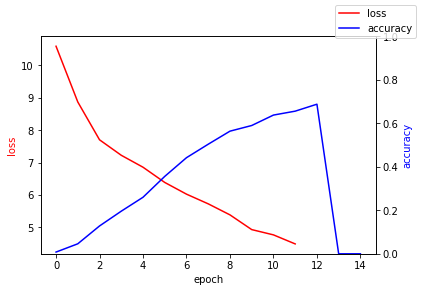

In [3]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy', color='blue')
ax2.set_ylim(0, 1)

ax1.plot(history.history['loss'], label='loss', color='red')
ax2.plot(history.history['accuracy'], label='accuracy', color='blue')
fig.legend()
plt.show()